In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
from modeling.modeling_utils import print_model_parameters

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Downloading...
From (original): https://drive.google.com/uc?id=1-lBUC933Kotv-_wUWlAH9EXILxL3AjT1
From (redirected): https://drive.google.com/uc?id=1-lBUC933Kotv-_wUWlAH9EXILxL3AjT1&confirm=t&uuid=a0997b46-1faa-4dc3-a6ef-0445e4303677
To: /workspace/intraday-portfolio-management/data/raw/alpaca/bars_with_quotes/1Min_2024-11-01-2026-01-01_AAPL+ACWI+AMD+AMZN+APLD+AVGO+BAC+BITB+BITU+BMY+BOIL+C+CIFR+CLSK+CSCO+DIA+DKNG+ETHA+EWY+FBTC+GBTC+GDX.pkl
100%|██████████| 1.37G/1.37G [00:11<00:00, 120MB/s] 


device(type='cuda')

In [2]:
retriever = config.data_config.retriever
retrieval_result = retriever.bars_with_quotes(
    symbol_or_symbols=config.data_config.symbol_or_symbols, 
    start=config.data_config.start, 
    end=config.data_config.end
)

2026-01-17 15:24:48,889 - INFO - ../data/raw/alpaca/bars_with_quotes/1Min_2024-11-01-2026-01-01_AAPL+ACWI+AMD+AMZN+APLD+AVGO+BAC+BITB+BITU+BMY+BOIL+C+CIFR+CLSK+CSCO+DIA+DKNG+ETHA+EWY+FBTC+GBTC+GDX.pkl
2026-01-17 15:24:48,894 - INFO - True
2026-01-17 15:24:48,906 - INFO - ['1Min_2024-11-01-2026-01-01_AAPL+ACWI+AMD+AMZN+APLD+AVGO+BAC+BITB+BITU+BMY+BOIL+C+CIFR+CLSK+CSCO+DIA+DKNG+ETHA+EWY+FBTC+GBTC+GDX.pkl', '1Min_2024-11-01-2026-01-01_AAPL+ACWI+AMD+AMZN+APLD+AVGO+BAC+BITB+BITU+BMY+BOIL+C+CIFR+CLSK+CSCO+DIA+DKNG+ETHA+EWY+FBTC+GBTC+GDX.pklmlb7liue.part']
2026-01-17 15:24:48,911 - INFO - ../data/raw/alpaca/bars_with_quotes/1Min_2024-11-01-2026-01-01_AAPL+ACWI+AMD+AMZN+APLD+AVGO+BAC+BITB+BITU+BMY+BOIL+C+CIFR+CLSK+CSCO+DIA+DKNG+ETHA+EWY+FBTC+GBTC+GDX.pkl
2026-01-17 15:24:48,914 - INFO - True


In [3]:
data_preparer = DataPreparer(
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler_polars,
    in_seq_len=config.data_config.in_seq_len,
    frequency=str(config.data_config.frequency),
    validator=config.data_config.validator
)

In [4]:
(X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
    data_preparer.get_experiment_data(
        data=retrieval_result,
        start_date=config.data_config.start,
        end_date=config.data_config.end,
        features=config.data_config.features_polars,
        statistics=config.data_config.statistics,
        target=config.data_config.target,
        train_set_last_date=config.data_config.train_set_last_date,
        val_set_last_date=config.data_config.val_set_last_date,
        backend='loky'
    )

X_train.shape, y_train.shape, statistics_train['next_return'].shape, \
    X_val.shape, y_val.shape, statistics_val['next_return'].shape, \
    X_test.shape, y_test.shape, statistics_test['next_return'].shape

2026-01-17 15:25:00,435 - INFO - Skipping day 2024-11-02 00:00:00-04:00 because it has less than 100 assets
2026-01-17 15:26:35,519 - INFO - Found 303 daily slices
2026-01-17 15:26:35,553 - INFO - Trained per-asset targets
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


((92667, 100, 60, 16),
 (92667, 100),
 (92667, 100),
 (8993, 100, 60, 16),
 (8993, 100),
 (8993, 100),
 (16813, 100, 60, 16),
 (16813, 100),
 (16813, 100))

In [5]:
# from observability.mlflow_integration import log_experiment


# log_experiment(
#     config=config, 
#     validator_snapshots=data_preparer.validator.snapshots
#     # model=model, 
#     # history=history,
# )

In [6]:
next_return_train, spread_train, volatility_train, \
    next_return_val, spread_val, volatility_val, \
    next_return_test, spread_test, volatility_test = \
        statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
        statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
        statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']

In [7]:
(volatility_test / spread_test).mean(axis=0).argsort()

array([47, 41, 85, 45, 65, 88, 10, 79, 58, 53,  6, 76, 12, 99, 81, 44, 51,
       38, 98, 42, 60, 37,  4, 95, 18, 32, 13, 43, 29, 62,  9, 84, 91, 90,
       40, 16, 39, 71, 25, 17, 50, 34, 72,  1, 48, 68, 59,  5, 54, 82, 30,
       11, 66, 77, 83, 35, 92, 31, 46, 14,  7, 87, 86, 28, 63, 64, 96,  2,
       69, 27, 52, 15,  8, 97, 21,  3, 55, 93, 61, 78, 20, 89, 57, 22, 73,
       26, 23, 80, 33, 24, 19, 67,  0, 75, 94, 36, 74, 70, 56, 49])

In [8]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.00073144585, 0.0002881666, 0.00093381474)

In [9]:
np.abs(next_return_val).mean(), spread_val.mean(), volatility_val.mean()

(0.00071344915, 0.00028816686, 0.0009065876)

In [10]:
np.abs(next_return_test).mean(), spread_test.mean(), volatility_test.mean()

(0.0006895776, 0.00028816672, 0.0008736083)

In [11]:
train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)
val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)

In [12]:
model = config.model_config.model
model

TemporalSpatial(
  (asset_embed): Embedding(100, 16)
  (asset_proj): Linear(in_features=16, out_features=256, bias=False)
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (spatial_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [13]:
print_model_parameters(model)

Module                                   Params
------------------------------------------------------------
[ROOT]                                   814401
asset_embed                              1600
asset_proj                               4096
lstm                                     544768
spatial_attn                             263168
spatial_attn.out_proj                    65792
fc                                       257
norm                                     512


In [14]:
config

ExperimentConfig(data_config=DataConfig(retriever=<data.raw.retrievers.alpaca_markets_retriever.AlpacaMarketsRetriever object at 0x776c7df55f90>, symbol_or_symbols=['AAPL', 'ACWI', 'AMD', 'AMZN', 'APLD', 'AVGO', 'BAC', 'BITB', 'BITU', 'BMY', 'BOIL', 'C', 'CIFR', 'CLSK', 'CSCO', 'DIA', 'DKNG', 'ETHA', 'EWY', 'FBTC', 'GBTC', 'GDX', 'GLD', 'GOOG', 'GOOGL', 'HOOD', 'IBIT', 'IGV', 'IJR', 'INTC', 'IONQ', 'IREN', 'ITOT', 'IVV', 'IVW', 'IWD', 'IWM', 'IYR', 'KO', 'KRE', 'MARA', 'META', 'MRK', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NFLX', 'NKE', 'NVDA', 'NVO', 'ORCL', 'PLTR', 'PYPL', 'QBTS', 'QLD', 'QQQ', 'QQQM', 'QUAL', 'RGTI', 'RIOT', 'RSP', 'SLV', 'SMCI', 'SMH', 'SMR', 'SOFI', 'SOXL', 'SOXX', 'SPXL', 'SPY', 'SPYG', 'SSO', 'TNA', 'TQQQ', 'TSLA', 'TSM', 'UBER', 'UPRO', 'VONG', 'VOO', 'VT', 'VTI', 'VTV', 'VTWO', 'VYM', 'WFC', 'WMT', 'WULF', 'XBI', 'XLB', 'XLC', 'XLE', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY', 'XOM', 'XRT'], frequency=<alpaca.data.timeframe.TimeFrame object at 0x776c7e805850>, start=datetime.da

In [15]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    early_stopping_patience=config.train_config.early_stopping_patience,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path
)

2026-01-17 15:32:37,852 - INFO - Model compiled with torch.compile()


In [16]:
model, history = trainer.train()

2026-01-17 15:32:38,046 - INFO - Epoch 1/20
Training:   0%|          | 0/723 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
2026-01-17 15:33:28,581 - INFO - Train Loss: 0.2471        
2026-01-17 15:33:28,582 - INFO - Train Rmse: 0.4955
2026-01-17 15:33:28,583 - INFO - Val   Loss: 0.2395
2026-01-17 15:33:28,584 - INFO - Val   Rmse: 0.4894
2026-01-17 15:33:28,585 - INFO - New best model found! Updating best state dict.
2026-01-17 15:33:28,591 - INFO - 
2026-01-17 15:33:28,592 - INFO - Epoch 2/20
2026-01-17 15:34:06,999 - INFO - Train Loss: 0.2330 

In [17]:
if False: 
    state_dict = torch.load(
        "../modeling/checkpoints/best_model.pth",
        map_location=device
    )

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_state_dict[k.replace("_orig_mod.", "")] = v
        else:
            new_state_dict[k] = v

    model = config.model_config.model
    model.load_state_dict(new_state_dict)

In [18]:
train_trajectory_loader = TrajectoryDataset(X_train, next_return_train, spread_train, volatility_train, \
        trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon, shift_data_within_horizon=True).as_dataloader(
    batch_size=8, 
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
val_trajectory_loader = TrajectoryDataset(X_val, next_return_val, spread_val, volatility_val, \
        trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)
test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
        trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)

In [ ]:
env = PortfolioEnvironment(
    reward_function=EstimatedReturnReward(fee=config.rl_config.fee, spread_multiplier=config.rl_config.spread_multiplier),
)

actor = RlActor(
    model,
    n_assets=len(retrieval_result),
    train_signal_predictor=False,
).to(device)

eval_actor = SignalPredictorActor(
    model, 
    trade_asset_count=config.rl_config.trade_asset_count,
    select_from_n_best=config.rl_config.choose_from_n_best,
    train_signal_predictor=False
).to(device)

# eval_actor = AllocationPropogationActor(
#     model, 
#     train_allocator=False
# ).to(device)

market_actor = MarketActor().to(device)

rl_agent = RlAgent(
    actor, 
    env
)

metrics_calculator = MetricsCalculator(
    metrics=DEFAULT_METRICS
)

policy_gradient = PolicyGradient(
    rl_agent, 
    train_trajectory_loader, 
    val_trajectory_loader, 
    metrics_calculator=metrics_calculator,
    optimizer=torch.optim.AdamW(
        [p for p in actor.parameters() if p.requires_grad], 
        lr=1e-3,
        weight_decay=1e-5,
        amsgrad=True),
    scheduler=None,
    loss_fn=ReinforceLoss(use_baseline=False),
    num_epochs=10,
    device=device
)

In [20]:
# policy_gradient.train()

In [21]:
print('Val set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor)

Val set evaluation


2026-01-17 15:46:39,249 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.4436, MeanReturnPercentage: 0.0041, ARR: 0.4436, AVOL: 0.0900, MDD: 8.9559, ASR: 4.9259, CR: 0.0495, DDR: 5.4007, SoR: 0.0477


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


In [22]:
print('Test set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor, test_trajectory_loader)

Test set evaluation


2026-01-17 15:47:29,308 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 1.9216, MeanReturnPercentage: 0.0064, ARR: 1.9216, AVOL: 0.1524, MDD: 16.5547, ASR: 12.6076, CR: 0.1161, DDR: 15.0562, SoR: 0.0655


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


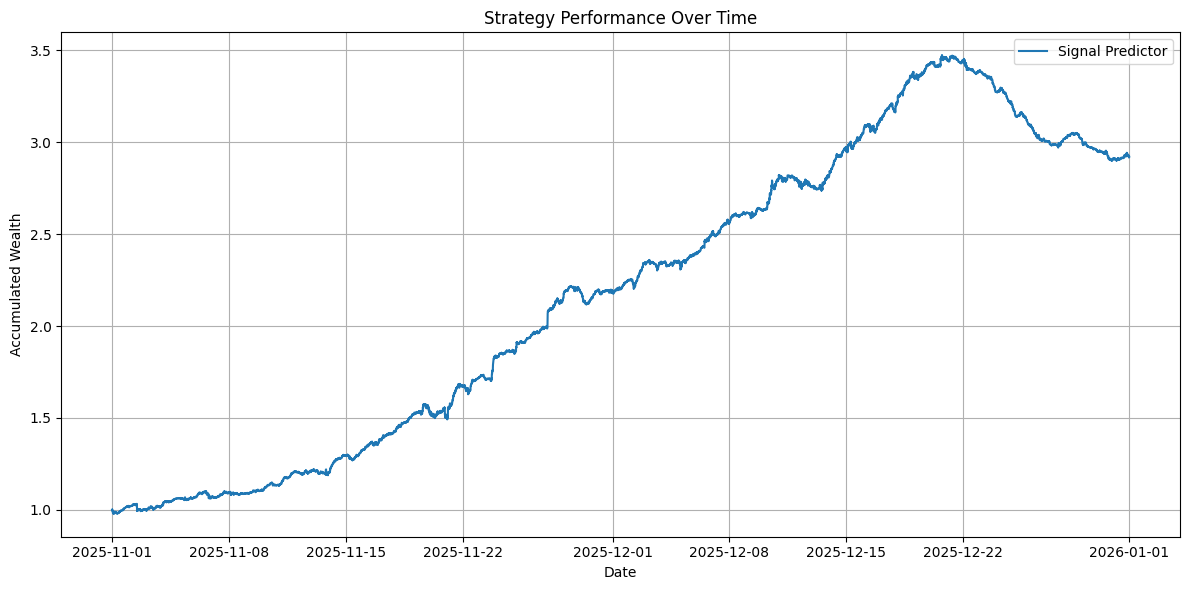

In [23]:
returns_dict = plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns_signal_predictor
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end,
    ours_to_include=[],
    baseline_to_include=[],
    year_start=9
)

In [22]:
for key, value in returns_dict.items():
    print(f'Metrics for {key}:')
    print(MetricsCalculator(
        metrics=DEFAULT_METRICS, n_years=10
    )(value))

Metrics for Ours:
{'CumulativeReturn': 3.8627943992614746, 'MeanReturnPercentage': 1.3420484960079193, 'ARR': 0.17135514856316325, 'AVOL': 0.1758959899545377, 'MDD': 19.271564483642578, 'ASR': 0.9741845087398066, 'CR': 0.008891605489974983, 'DDR': 1.2872895277939824, 'SoR': 0.36351218819618225}
Metrics for Ours-NA:
{'CumulativeReturn': 3.2330942153930664, 'MeanReturnPercentage': 1.2382958084344864, 'ARR': 0.15522291097194274, 'AVOL': 0.17979335276654979, 'MDD': 23.229753971099854, 'ASR': 0.863340655165877, 'CR': 0.006682072964055307, 'DDR': 1.2906608181144166, 'SoR': 0.37123796343803406}
Metrics for Ours-NE:
{'CumulativeReturn': 2.576979398727417, 'MeanReturnPercentage': 1.108118798583746, 'ARR': 0.1359301947061229, 'AVOL': 0.1787127436117978, 'MDD': 16.28894805908203, 'ASR': 0.760607173047448, 'CR': 0.008344933890947853, 'DDR': 0.9349207787769759, 'SoR': 0.2748000919818878}
Metrics for Ours-NEA:
{'CumulativeReturn': 2.4243900775909424, 'MeanReturnPercentage': 1.0823746211826801, 'ARR'

In [24]:
root_dir = '../modeling/rl/visualization'
realized_returns_signal_predictor = \
    list(pd.read_csv(os.path.join(root_dir, f'results_ours', f'realized_returns_ours-na.csv'))['0'])

In [25]:
metrics = MetricsCalculator(
    metrics=DEFAULT_METRICS
)(realized_returns_signal_predictor)
metrics

{'CumulativeReturn': 3.2330942153930664,
 'MeanReturnPercentage': 1.2382958084344864,
 'ARR': 3.2330942153930664,
 'AVOL': 0.5685565029004331,
 'MDD': 23.229753971099854,
 'ASR': 5.686495887215721,
 'CR': 0.13917901237418873,
 'DDR': 8.501090954170314,
 'SoR': 0.37123796343803406}

In [26]:
0.1675 / 0.3853

0.4347261873864522

In [26]:
sum(actions_signal_predictor[0])

0.9999998807907104

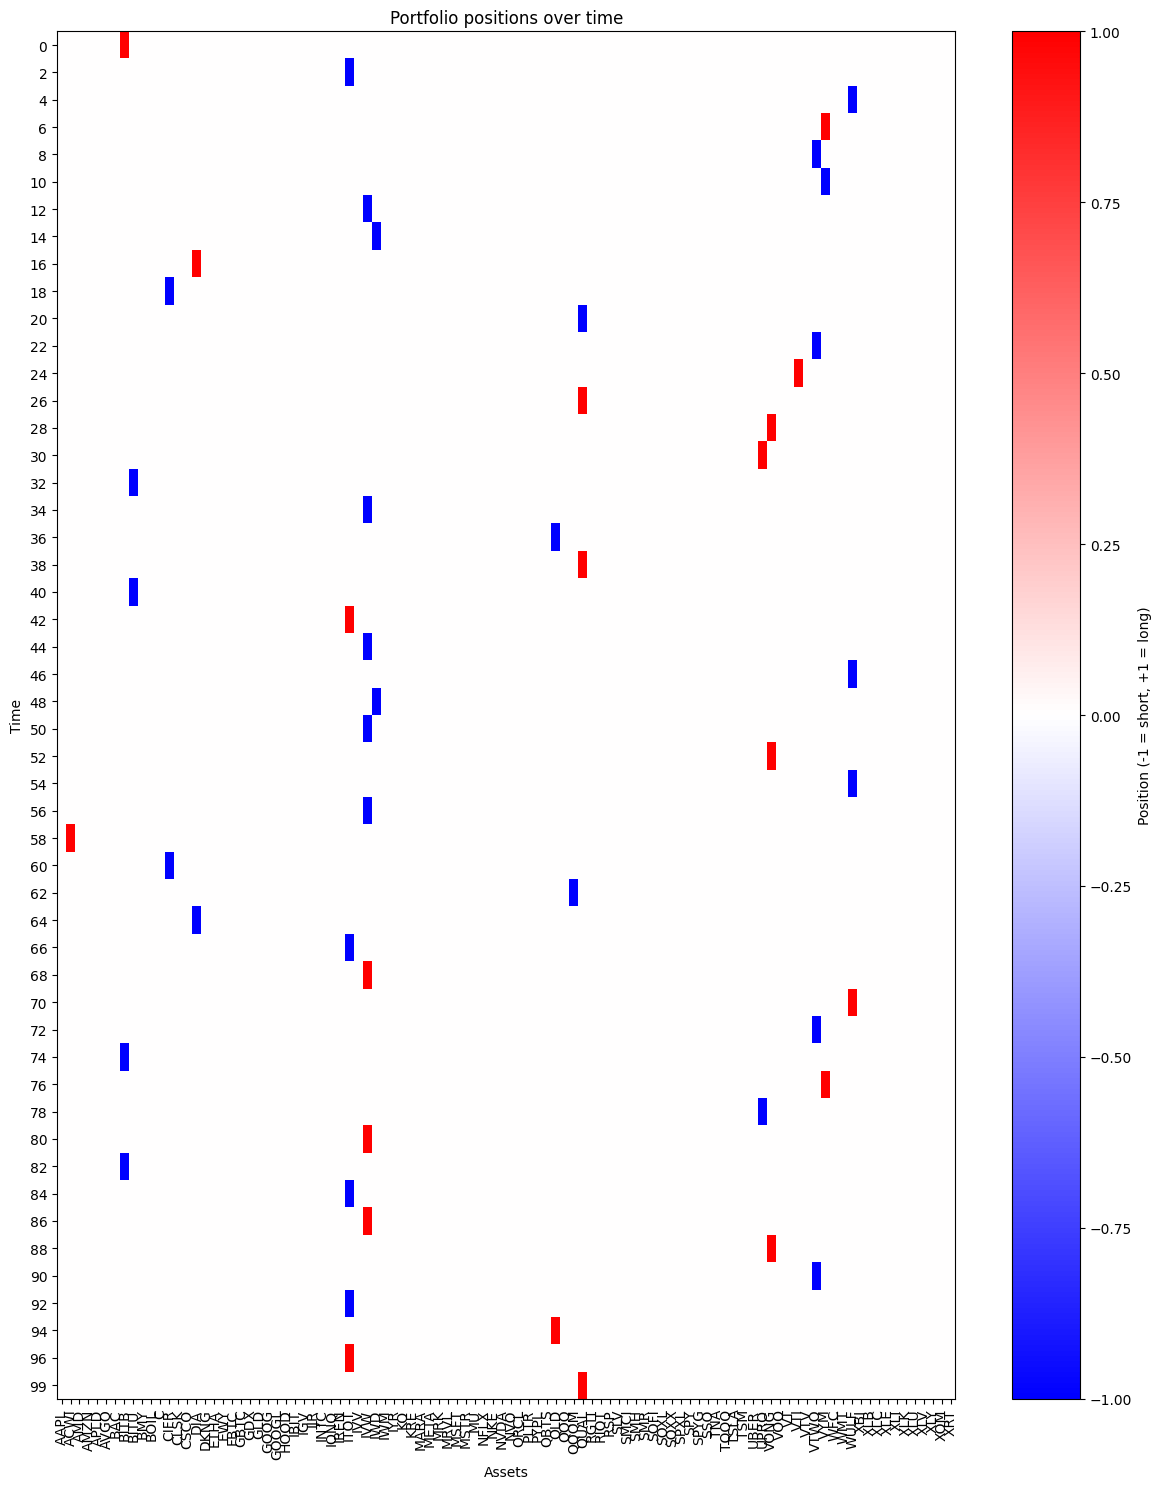

In [25]:
plot_position_heatmap(actions_signal_predictor[:100], asset_names=sorted(list(retrieval_result.keys())))

In [29]:
import copy  # Local import to avoid polluting global namespace unnecessarily
state_dict = (
    model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
    else model.state_dict()
)

# Keep a local copy of the best weights so we can return the best model
# after training finishes, without needing to reload from disk.
best_model_state = copy.deepcopy(state_dict)

# Persist to disk if a save_path was provided
torch.save(state_dict, "best_model.pth")